In [1]:
import numpy as np

sent = 'you will never know until you try'
tokens = sent.split()

V = len(set(tokens)) # 6
N = 4

# 가중치 행렬
W1 = np.random.rand(V, N)
W2 = np.random.rand(V, N)

In [2]:
# 원핫인코딩 + 단어-인덱스 딕셔너리, 인덱스-단어 딕셔너리 생성
onehot_vector = np.zeros(shape=(V, V), dtype=np.int32) 
unique_tokens = set(tokens)

word2idx = {}
for idx, word in enumerate(unique_tokens):
    onehot_vector[idx][idx] = 1
    word2idx[word] = idx

idx2word = {v: k for k, v in word2idx.items()}

print(onehot_vector)
print(word2idx)
print(idx2word)

[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]
{'try': 0, 'never': 1, 'you': 2, 'know': 3, 'will': 4, 'until': 5}
{0: 'try', 1: 'never', 2: 'you', 3: 'know', 4: 'will', 5: 'until'}


In [3]:
# 학습 데이터 생성
window_size = 1

training_data = []
for i, token in enumerate(tokens):
    target_word = token
    context_words = []
    for window in range(1, window_size+1):
        if i-window >= 0:
            context_words.append(tokens[i-window])
        if i+window < len(tokens):
            context_words.append(tokens[i+window])
    # context_words = [tokens[i-1], tokens[i+1]]

    training_data.append([context_words, target_word])

In [5]:
W1, W2

(array([[0.87235086, 0.47503846, 0.83261872, 0.21165417],
        [0.62061969, 0.83621552, 0.97178442, 0.56747298],
        [0.41925062, 0.58275004, 0.85162616, 0.16965313],
        [0.23858864, 0.81426251, 0.7179529 , 0.85085677],
        [0.54561309, 0.31467396, 0.64061631, 0.09625703],
        [0.49274757, 0.27153005, 0.54350758, 0.57779887]]),
 array([[0.20623447, 0.2770732 , 0.27245003, 0.11269672],
        [0.80690022, 0.423254  , 0.59119545, 0.78109183],
        [0.62219848, 0.53342217, 0.31353669, 0.71292211],
        [0.38211847, 0.4767688 , 0.38615146, 0.36163264],
        [0.25900878, 0.81894299, 0.56928358, 0.40648394],
        [0.73118165, 0.97052564, 0.59590417, 0.1926154 ]]))

In [4]:
training_data

[[['will'], 'you'],
 [['you', 'never'], 'will'],
 [['will', 'know'], 'never'],
 [['never', 'until'], 'know'],
 [['know', 'you'], 'until'],
 [['until', 'try'], 'you'],
 [['you'], 'try']]

In [6]:
onehot_vector, word2idx

(array([[1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]], dtype=int32),
 {'try': 0, 'never': 1, 'you': 2, 'know': 3, 'will': 4, 'until': 5})

In [14]:
def softmax(a) :
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

In [46]:
# Word2Vec 학습 구현

# 4. Epoch
#   - epoch 수 만큼 반복
epochs = 20

learning_rate = 0.02

loss_list = []
for epoch in range(epochs):
    for context_words, target_word in training_data: 
        # 1. Feed Forward
        #   - context 단어를 W1 행렬에 곱해서 hidden vector 만들기
        #   - 만든 hidden vector들 평균내기
        vector_list = []
        for word in context_words:
            vector_list.append(onehot_vector[word2idx[word]])
        # print(vector_list)
        x = np.vstack(vector_list)
        # print(x) # (1, 2) x V
        # W1 -> V x N
        hidden_vector = x.dot(W1) # (1, 2) x N -> Hidden Vector
        # print(hidden_vector)
        # hidden_vector_avg = np.sum(hidden_vector, axis=0)/len(hidden_vector)
        # print(hidden_vector_avg) # (N, )

        #   - 평균낸 hidden vector를 가지고 W2에 곱해서 Vx1 크기의 벡터로 만들기
        #   - softmax 씌워서 합이 1이 되도록 조정
        # hidden_vector_avg.reshape(1, N).dot(W2.T) # (1, N) N * V ( 1 x V )
        # output_layer = W2.dot(hidden_vector_avg) # V x N * N x 1 -> V x 1
        
        output_layer = W2.dot(hidden_vector.T) # V x N * N x (1, 2)
        # print(output_layer) # V x (1, 2)
        output_layer = softmax(output_layer)
        # print(output_layer)
        real_vector = onehot_vector[word2idx[target_word]]
        # print(real_vector)

        # 2. Loss 계산
        #   - cross entropy loss
        loss = -np.sum(real_vector.reshape(-1, 1) * np.log(output_layer)) / len(hidden_vector)
        # print(loss)
        loss_list.append(loss)

        # 3. Backpropagation
        #   - 각 행렬에 대해서 편미분한 기울기 구하기
        #   - 각 행렬에 대해 기울기 * learning rate 만큼 가중치 update
        
        # W2 기울기
        # Y_hat - Y
        diff = output_layer - real_vector.reshape(-1, 1) # V x (1, 2) - real_vector (V, 1) numpy broadcast 활용
        # print(diff) # V x (1, 2)
        # Hidden Vector와 dot_product -> V x N
        # V x (1, 2) * (1, 2) x N -> V x N
        gradient_w2 = diff.dot(hidden_vector)
        # print(gradient_w2)

        # W1 기울기 V x N
        # X * (W2 * diff) -> (1, 2) x V * ( V x N * V x (1, 2) )
        # ( V x N * V x (1, 2) ) -> (1, 2) x N
        # V x (1, 2) * (1, 2) x N -> V x N
        temp = diff.T.dot(W2) # (1, 2)x V * V x N -> (1, 2) x N
        gradient_w1 = x.T.dot(temp) # V x (1, 2) * (1, 2) x N -> V x N
        # print(gradient_w1)

        W1 -= learning_rate * gradient_w1
        W2 -= learning_rate * gradient_w2

In [47]:
word2idx

{'try': 0, 'never': 1, 'you': 2, 'know': 3, 'will': 4, 'until': 5}

In [48]:
sent = 'you will never know until you try'

w1v = W1[word2idx['never']]
w2v = W1[word2idx['until']]

cos_sim = lambda x, y : np.sum(x * y) / (np.linalg.norm(x) * np.linalg.norm(y))
cos_sim(w1v, w2v)

0.8789481252209215

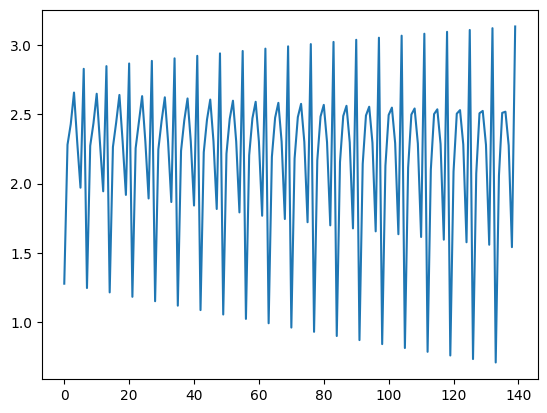

In [49]:
from matplotlib import pyplot as plt

plt.plot(loss_list)

In [ ]:
# 대량 데이터 처리

# 1. 입력 개선 (onehot_vector를 만들지 않고, word2idx 딕셔너리 통해서 hidden_layer를 계산)
# 2. loss 계산이 전체 단어에 대해서 1, 0을 계산하는게 아니라 해당 target_word만 1, 0 binary cross entropy 계산
# (sigmoid 함수 output_layer에)
# 3. (오답도 학습을 하기 위해 sampling을 통해서 0으로 예측해야 되는 단어들도 같이 학습시킨다.) W2에서 index를 통해 뽑아서 행렬곱 
# (output_layer들 각각 나온다.)


# 문맥 단어, 타겟 단어 (2천만개)
# 4. batch_size (속도 개선)
# 128개씩, 256개씩

# 2천만번 계산할 것인지
# 15만 6천번 연산할 것인지


In [53]:
training_data
training_data2 = []
for context_words, target_word in training_data:
    for word in context_words:
        training_data2.append([word, target_word])
training_data

[[['will'], 'you'],
 [['you', 'never'], 'will'],
 [['will', 'know'], 'never'],
 [['never', 'until'], 'know'],
 [['know', 'you'], 'until'],
 [['until', 'try'], 'you'],
 [['you'], 'try']]

In [55]:
training_data2

[['will', 'you'],
 ['you', 'will'],
 ['never', 'will'],
 ['will', 'never'],
 ['know', 'never'],
 ['never', 'know'],
 ['until', 'know'],
 ['know', 'until'],
 ['you', 'until'],
 ['until', 'you'],
 ['try', 'you'],
 ['you', 'try']]